In [1]:
import mysql.connector
# library for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import cosine_similarity

import os 

In [2]:
# Membuat koneksi ke database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='absensi'
)

In [3]:
# Mengeksekusi query untuk mengambil data dari tabel

query = "SELECT * FROM tourism"
destination = pd.read_sql_query(query, conn)

query = "SELECT * FROM ratings"
ratings = pd.read_sql_query(query, conn)

query = "SELECT * FROM users"
users = pd.read_sql_query(query, conn)

C:\Users\dewan\AppData\Local\Temp\ipykernel_21352\936973263.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  destination = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_21352\936973263.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratings = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_21352\936973263.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  users = pd.read_sql_query(query, conn)


In [7]:
print(f'number of tourist destination = {len(destination.Place_Id.unique())}')
print(f'number of user = {len(ratings.User_Id.unique())}')

number of tourist destination = 437
number of user = 301


In [8]:
destination = destination.drop(['Coordinate', 'Time_Minutes'], axis=1)
destination.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.17539,106.8272
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,5000,4.6,-6.13764,106.8171


## Collaborative Filtering
Collaborative Filtering uses algorithms to filter data from user reviews to make personalized recommendations for users with similar preferences

### Split data for Training and Testing

In [9]:
train, test = train_test_split(ratings, test_size = 0.2)

In [10]:
print(train.shape)
print(test.shape)

(8000, 3)
(2001, 3)


In [11]:
number_user = len(ratings['User_Id'].unique())
number_destination = len(ratings['Place_Id'].unique())

print(f'number of user = {number_user}')
print(f'number of place name = {number_destination}')

number of user = 301
number of place name = 438


In [12]:
# build recommendation system using emmbedding layers dan dropout(to overcome the overfitting)

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout 

EMBEDDING_DIM = 50

# input layers 
place_input = Input(shape=[1])
user_input = Input(shape=[1])

# embedding layers add dropout 
place_embedding = Embedding(number_destination+1 , EMBEDDING_DIM)(place_input)
place_embedding = Dropout(0.2)(place_embedding)

user_embedding = Embedding(number_user+1 , EMBEDDING_DIM)(user_input)
user_embedding = Dropout(0.2)(user_embedding)

# flatten the embedddings
place_flat = Flatten()(place_embedding)
user_flat = Flatten()(user_embedding)

# output layer
output = Dot(1)([place_flat, user_flat])

# the model
model = Model([place_input, user_input], [output])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error') 

In [15]:
history = model.fit(x= [train.Place_Id, train.User_Id], 
                    y= train.Place_Ratings, 
                    validation_data = ([test.Place_Id, test.User_Id], test.Place_Ratings), 
                    epochs =100,
                    callbacks=[early_stopping])

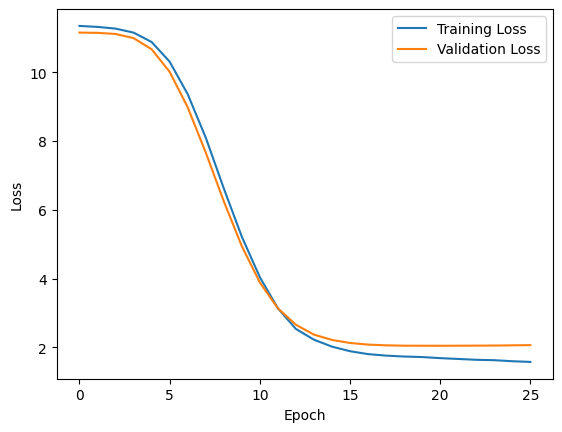

In [16]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Function for filtered by city, user_lat, & user_long

In [9]:
# calculations for "haversine distance" and complementary functions for collaborative filtering
from math import radians

def haversine_distance(lat1, long1, lat2, long2):
    earth_radius = 6371  # Radius of the Earth in kilometers (source: google)
    lat1_rad = np.radians(lat1)
    long1_rad = np.radians(long1)
    lat2_rad = np.radians(lat2)
    long2_rad = np.radians(long2)
    diff_lat = lat2_rad - lat1_rad
    diff_long = long2_rad - long1_rad
    a = np.sin(diff_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(diff_long / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = earth_radius * c
    return distance

def filter_by_location(destination, user_lat, user_long, max_distance):
    destination['distance'] = haversine_distance(destination['Lat'], destination['Long'], user_lat, user_long)
    destination = destination[destination['distance'] <= max_distance]
    destination = destination.drop('distance', axis=1)
    return destination

def filter_by_city(destination):
    city_filter = ['Jakarta', 'Bandung', 'Yogyakarta', 'Semarang', 'Surabaya']
    destination = destination[destination['City'].isin(city_filter)]
    return destination

In [93]:
# recommendation system function using collaborative filtering
def collaborative_rec(User_Id, destination ,model, np_val, user_location = '', ):
    # detail user : digunakan untuk menyimpan data detail user untuk mengerucutkan data yang akan di outputkan
    
    if User_Id in ratings['User_Id'].values:
            destination = destination.copy()
            user_ids = np.array([User_Id] * len(destination))
            results = model([destination.Place_Id.values, user_ids]).numpy().reshape(-1)
    
            destination['predicted_rating'] = pd.Series(results)
            destination = destination.sort_values('predicted_rating', ascending = False)
    else:
            destination = destination.copy()
            destination = destination.sort_values('Rating', ascending = False)
    
    if user_location != '':
        destination = destination[destination['City'] == user_location]
    
    dataFinal = destination[:np_val]
    
    return dataFinal['Place_Id'].tolist()

In [86]:
user_location = 'Bandung'

In [96]:
collaborative_rec(34, destination, model, 5, user_location)

[322, 249, 332, 321, 230]

In [91]:
collaborative_rec(34, destination, model, 5)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,predicted_rating
415,416,Keraton Surabaya,Kawasan yang berjuluk Kampung Keraton ini terd...,Budaya,Surabaya,0,4.4,0,"{'lat': -7.256755299999998, 'l",-7.25676,112.7942,4.086581
321,322,Bukit Jamur,Bukit Jamur Ciwidey adalah satu dari sekian ba...,Cagar Alam,Bandung,13000,4.2,0,"{'lat': -7.195110199999998, 'l",-7.19511,107.4313,4.048257
96,97,Monumen Yogya Kembali,Museum Monumen Yogya Kembali (bahasa Jawa: ê¦©...,Budaya,Yogyakarta,15000,4.5,30,"{'lat': -7.7495904, 'lng': 110",-7.74959,110.3696,3.843433
427,428,Monumen Bambu Runcing Surabaya,Monumen Bambu Runcing adalah ikon pariwisata S...,Budaya,Surabaya,0,4.6,15,"{'lat': -7.267775500000001, 'l",-7.26778,112.7444,3.794878
248,249,Upside Down World Bandung,Upside Down World Bandung pertama kali dibuka ...,Taman Hiburan,Bandung,100000,4.0,30,"{'lat': -6.896300000000001, 'l",-6.89630,107.6170,3.786322


In [92]:
collaborative_rec(34, destination, model, 5, user_location)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,predicted_rating
321,322,Bukit Jamur,Bukit Jamur Ciwidey adalah satu dari sekian ba...,Cagar Alam,Bandung,13000,4.2,0,"{'lat': -7.195110199999998, 'l",-7.19511,107.4313,4.048257
248,249,Upside Down World Bandung,Upside Down World Bandung pertama kali dibuka ...,Taman Hiburan,Bandung,100000,4.0,30,"{'lat': -6.896300000000001, 'l",-6.89630,107.6170,3.786322
331,332,Rainbow Garden,Rainbow Garden Harapan Indah salah satu taman ...,Cagar Alam,Bandung,20000,4.6,90,"{'lat': -6.8179514, 'lng': 107",-6.81795,107.6189,3.772531
320,321,Glamping Lakeside Rancabali,Glamping Lakeside Rancabali menawarkan tempat ...,Taman Hiburan,Bandung,30000,4.4,0,"{'lat': -7.167590799999999, 'l",-7.16759,107.3532,3.713035
229,230,Stone Garden Citatah,"Stone Garden, adalah sebutan nama untuk hampar...",Taman Hiburan,Bandung,30000,4.4,0,"{'lat': -6.8281528, 'lng': 107",-6.82815,107.4350,3.696679


<H1>Recomendation system based from category</H1>

In [10]:
# fungsi untuk melakukan groouping data
def groupingCategory(df, budget, totalCategory, excepts = []):
    data = []
    
    if len(excepts) == 0:
        for idx, row in df.iterrows():
            if len(data) == totalCategory:
                break
            if row['Price'] < budget:
                data.append(row['Place_Id'])
                budget -= row['Price']    
    else:
        for x in excepts:
            if df['Place_Id'].eq(x).any():
                df = df.loc[df['Place_Id'] != x]
                
        for idx, row in df.iterrows():
            if len(data) == totalCategory:
                break
            if row['Price'] < budget:
                data.append(row['Place_Id'])
                budget -= row['Price']
        
    return data

In [14]:
# Function to recommend places based on user input
def recommend_places(df, category, city, price, rating, lat, long, top_n=50):
    # Filter dataset based on user input
    filtered_df = df[(df['Category'] == category) & (df['City'] == city) & (df['Price'] <= price) & (df['Rating'] >= rating)]
    
    # Calculate cosine similarity between user input and dataset
    user_input = [[price, rating, lat, long]]
    dataset = filtered_df[['Price', 'Rating', 'Lat', 'Long']]
    similarity_matrix = cosine_similarity(user_input, dataset)
    
    # Sort places based on similarity score
    filtered_df['Similarity'] = similarity_matrix[0]
    recommended_places = filtered_df.sort_values(by='Similarity', ascending=False).head(top_n)
    
    gold = []
    silver = []
    bronze = []
    
    gold = groupingCategory(recommended_places, price, 5)
    silver = groupingCategory(recommended_places, price, 5, gold)
    bronze = groupingCategory(recommended_places, price, 5, (silver + gold))
                
    return recommended_places

In [12]:
# Example usage
category = 'Taman Hiburan'
city = 'Jakarta'
price = 50000
rating = 4.0
lat = -6.20000
long = 106.80000

In [15]:
recommendations = recommend_places(destination, category, city, price, rating, lat, long)
recommendations

C:\Users\dewan\AppData\Local\Temp\ipykernel_21352\467043432.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Similarity'] = similarity_matrix[0]


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long,Similarity
27,28,Wisata Agro Edukatif Istana Su,Kawasan Wisata Agro Edukatif Istana Susu â€œCi...,Taman Hiburan,Jakarta,35000,4.5,-6.35681,106.9062,1.000000
61,62,Taman Legenda Keong Emas,Taman Legenda Keong Emas merupakan salah satu ...,Taman Hiburan,Jakarta,30000,4.5,-6.30390,106.8936,0.999999
5,6,Taman Impian Jaya Ancol,Taman Impian Jaya Ancol merupakan sebuah objek...,Taman Hiburan,Jakarta,25000,4.5,-6.11733,106.8580,0.999998
75,76,Taman Cattleya,Kehadiran Taman Cattleya tentu saja sangat ber...,Taman Hiburan,Jakarta,20000,4.5,-6.18108,106.7954,0.999995
50,51,Jakarta Planetarium,Planetarium dan Observatorium Jakarta adalah s...,Taman Hiburan,Jakarta,12000,4.1,-6.19008,106.8389,0.999977
3,4,Taman Mini Indonesia Indah (TM,Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,-6.30245,106.8952,0.999963
36,37,Bumi Perkemahan Cibubur,Bumi Perkemahan dan Graha Wisata Pramuka Cibub...,Taman Hiburan,Jakarta,10000,4.5,-6.36025,106.8938,0.999963
77,78,Hutan Kota Srengseng,Selain Taman Hutan Mangrove dan Pantai Indah K...,Taman Hiburan,Jakarta,1000,4.3,-6.21069,106.7644,0.994546
53,54,Taman Agrowisata Cilangkap,Taman seluas sekitar 19 hektar ini dimiliki ol...,Taman Hiburan,Jakarta,0,4.2,-6.34015,106.9013,0.002141
76,77,Taman Hutan Tebet,"Taman Tebet dibangun tahun 1960, taman ini sem...",Taman Hiburan,Jakarta,0,4.4,-6.23714,106.8527,0.002141


<H1>Recomendation system based from Destination</H1>

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity 

In [49]:
# merge rating dataset with destination dataset on Place_Id column 
full = pd.merge(ratings, destination[['Place_Id', 'Place_Name', 'Category', 'Description']], on = 'Place_Id',
                        how = 'left')

# merge full dataset (destination & rating) with user dataset (age's column)
merged_df = pd.merge(full, users, on='User_Id')

In [54]:
preapare = merged_df

# sort merged_df by Place_Id
merged_df = merged_df.sort_values('Place_Id')
# drop duplicates 
merged_df = merged_df.sort_values('Place_Id', ascending = True).drop_duplicates(subset = ['Place_Id', 'User_Id'])

In [55]:
# new variable for content based filtering 
place_id = destination['Place_Id'].unique().tolist()
place_name = destination['Place_Name'].unique().tolist()
place_category = destination['Category'].tolist()

In [56]:
# dictionary for place_recommend
place_recommend = pd.DataFrame({
    'place_id' : place_id,
    'place_name' : place_name,
    'place_category' : place_category
})

In [57]:
# data frame for content based filtering 
data_content = place_recommend

In [58]:
tfidf= TfidfVectorizer()
tfidf.fit(data_content['place_name'])

TfidfVectorizer()

In [59]:
# change data into matrix 
tfidf_matrix = tfidf.fit_transform(data_content['place_name'])

In [60]:
# change vector TF-IDF into matrix 
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
# calculate the cosine similairty between the place name and each entry in 
result_cosine_similarity = cosine_similarity(tfidf_matrix)

In [106]:
data_content

,place_id,place_name,place_category
0,1,Monumen Nasional,Budaya
1,2,Kota Tua,Budaya
2,3,Dunia Fantasi,Taman Hiburan
3,4,Taman Mini Indonesia Indah (TM,Taman Hiburan
4,5,Atlantis Water Adventure,Taman Hiburan
...,...,...,...
432,433,Museum Mpu Tantular,Budaya
433,434,Taman Bungkul,Taman Hiburan
434,435,Taman Air Mancur Menari Kenjer,Taman Hiburan
435,436,Taman Flora Bratang Surabaya,Taman Hiburan


In [103]:
df_cosine_similarity = pd.DataFrame(cosine_similarity, index = data_content['place_name'], columns = data_content['place_name'])

In [115]:
# recommendation function for content based filtering 

def content_rec(place_name, similarity_data = df_cosine_similarity, items = data_content[['place_id','place_name', 'place_category']], k = 5) :
  index = similarity_data.loc[:, place_name].to_numpy().argpartition(
      range(-1, -k, -1)
  )

  closest = similarity_data.columns[index[-1:-(k+2): -1]]
  closest = closest.drop(place_name, errors = 'ignore')
  
  result = pd.DataFrame(closest).merge(items).head(k)
  
  return result['place_id'].tolist()

In [116]:
# test the function
content_rec('The Lost World Castle')

[117, 27, 234, 311, 43]

In [114]:
content_rec('The Lost World Castle')

,place_name,place_id,place_category
0,The World Landmarks - Merapi P,117,Taman Hiburan
1,Sea World,27,Taman Hiburan
2,Amazing Art World,234,Budaya
3,The Lodge Maribaya,311,Cagar Alam
4,The Escape Hunt,43,Taman Hiburan
